In [1]:
# Preparation
# DataFrame
import pandas as pd

# Matplot`
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
# Preparation
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pj5493/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Preparation
# DATASET
DATASET_COLUMNS = ["ids", 'text', "target"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.9

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.3, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [4]:
## Training Part
dataset_path = os.path.join("train_Marked (1).csv") # open train csv file
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING) 

Open file: train_Marked (1).csv


In [5]:
print("Dataset size:", len(df))

Dataset size: 127889


In [6]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [7]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 90 ms, sys: 3.91 ms, total: 93.9 ms
Wall time: 98.6 ms


In [8]:
decode_map = {0: "NEGATIVE", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

Text(0.5, 1.0, 'Dataset labels distribuition')

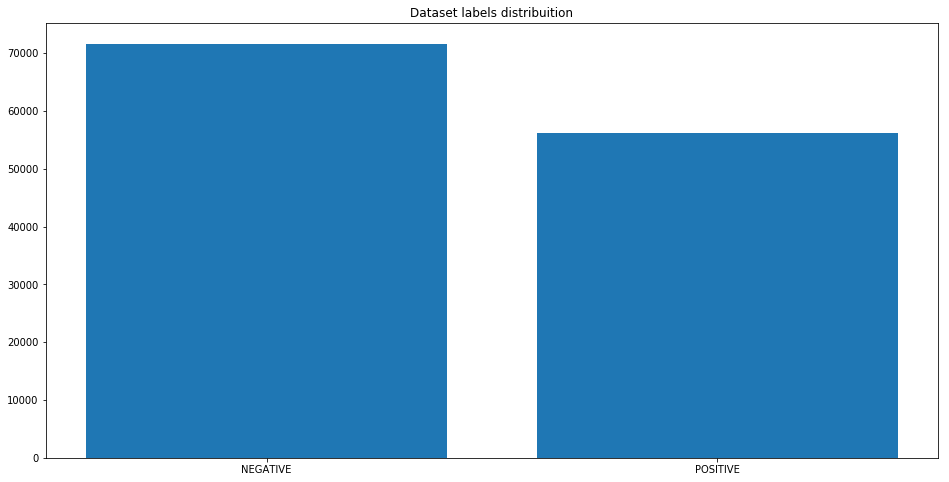

In [9]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [10]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 6.92 s, sys: 124 ms, total: 7.04 s
Wall time: 7.12 s


In [13]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
#print("TRAIN size:", len(df_train))
#print("TEST size:", len(df_test))
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 115100
TEST size: 12789


In [14]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: user 325 ms, sys: 56.1 ms, total: 381 ms
Wall time: 386 ms


In [15]:
documents = [_text.split() for _text in df_train.text]

In [16]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [17]:
w2v_model.build_vocab(documents)

In [18]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 7104


In [19]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 2min 40s, sys: 1.38 s, total: 2min 42s
Wall time: 54.2 s


(27051634, 34464864)

In [20]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 40685
CPU times: user 3.03 s, sys: 20.2 ms, total: 3.05 s
Wall time: 3.07 s


In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

In [22]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 3.33 s, sys: 127 ms, total: 3.46 s
Wall time: 3.48 s


In [23]:
labels = df_train.target.unique().tolist()
labels

['POSITIVE', 'NEGATIVE']

In [24]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (115100, 1)
y_test (12789, 1)


In [25]:
len(tokenizer.word_index.items())

40684

In [26]:
vocab_size

7104

In [27]:
W2V_SIZE

300

In [28]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 7104


In [29]:
embedding_matrix = np.zeros((70520, W2V_SIZE))

n=0
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
       
        embedding_matrix[i] = w2v_model.wv[word]
        #print(w2v_model.wv[word])
print(embedding_matrix.shape)

(70520, 300)


In [30]:
embedding_layer = Embedding(70520, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

W0808 12:20:51.824830 140736979424192 deprecation_wrapper.py:119] From /Users/pj5493/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [31]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

W0808 12:20:53.947052 140736979424192 deprecation_wrapper.py:119] From /Users/pj5493/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 12:20:53.961700 140736979424192 deprecation_wrapper.py:119] From /Users/pj5493/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0808 12:20:53.993022 140736979424192 deprecation_wrapper.py:119] From /Users/pj5493/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0808 12:20:53.995536 140736979424192 deprecation_wrapper.py:119] From /Users/pj5493/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto i

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          21156000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 21,316,501
Trainable params: 160,501
Non-trainable params: 21,156,000
_________________________________________________________________


In [32]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

W0808 12:20:57.111579 140736979424192 deprecation_wrapper.py:119] From /Users/pj5493/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0808 12:20:57.176290 140736979424192 deprecation.py:323] From /Users/pj5493/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [33]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [34]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 103590 samples, validate on 11510 samples
Epoch 1/8
103590/103590 [==============================] - 967s 9ms/step - loss: 0.3685 - acc: 0.8334 - val_loss: 0.1141 - val_acc: 0.9605
Epoch 2/8
103590/103590 [==============================] - 1012s 10ms/step - loss: 0.1495 - acc: 0.9448 - val_loss: 0.0450 - val_acc: 0.9847
Epoch 3/8
103590/103590 [==============================] - 1217s 12ms/step - loss: 0.0904 - acc: 0.9682 - val_loss: 0.0248 - val_acc: 0.9915
Epoch 4/8
103590/103590 [==============================] - 1170s 11ms/step - loss: 0.0638 - acc: 0.9785 - val_loss: 0.0176 - val_acc: 0.9934
Epoch 5/8
103590/103590 [==============================] - 1124s 11ms/step - loss: 0.0483 - acc: 0.9835 - val_loss: 0.0131 - val_acc: 0.9952
Epoch 6/8
103590/103590 [==============================] - 1192s 12ms/step - loss: 0.0385 - acc: 0.9869 - val_loss: 0.0113 - val_acc: 0.9959
Epoch 7/8
103590/103590 [==============================] - 1043s 10ms/step - loss: 0.0305 - acc: 0.9896 -

In [38]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

12789/12789 [==============================] - 34s 3ms/step

ACCURACY: 0.9955430458714101
LOSS: 0.014956153275909564
CPU times: user 1min 26s, sys: 28 s, total: 1min 54s
Wall time: 37.2 s


In [39]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

12789/12789 [==============================] - 32s 3ms/step


Train on 103590 samples, validate on 11510 samples
Epoch 1/8
103590/103590 [==============================] - 992s 10ms/step - loss: 0.0248 - acc: 0.9914 - val_loss: 0.0097 - val_acc: 0.9964
Epoch 2/8
103590/103590 [==============================] - 1041s 10ms/step - loss: 0.0214 - acc: 0.9925 - val_loss: 0.0095 - val_acc: 0.9964
Epoch 3/8
103590/103590 [==============================] - 1023s 10ms/step - loss: 0.0202 - acc: 0.9929 - val_loss: 0.0090 - val_acc: 0.9965
Epoch 4/8
103590/103590 [==============================] - 1097s 11ms/step - loss: 0.0190 - acc: 0.9933 - val_loss: 0.0091 - val_acc: 0.9965
Epoch 5/8
103590/103590 [==============================] - 1043s 10ms/step - loss: 0.0181 - acc: 0.9938 - val_loss: 0.0086 - val_acc: 0.9964
Epoch 6/8
103590/103590 [==============================] - 1013s 10ms/step - loss: 0.0170 - acc: 0.9938 - val_loss: 0.0085 - val_acc: 0.9964


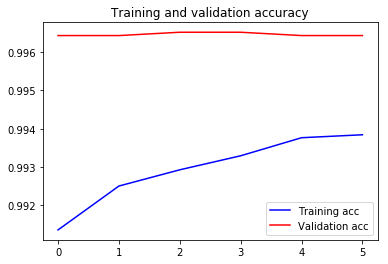

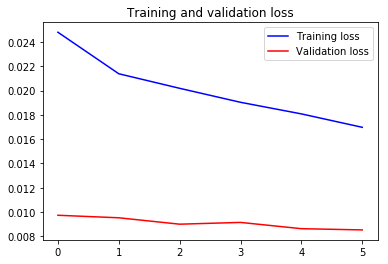

In [42]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

In [41]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)